In [1]:
import pandas as pd
import numpy as np
import random

In [24]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate","none"]
index=['Probabilities','Labels']

In [41]:
output = pd.DataFrame(index=index,columns=list_classes)
data = np.array([.91,.52,.83,.54,.65,.96,.97])


In [49]:
output.loc['Labels'] = [1 if output.loc['Probabilities'][i]>0.7 else 0 for i in range(len(list_classes))]

In [50]:
output.loc['Probabilities']=data

# output.loc['Label'] = [1 if output[i] > 1 else 0 for i in list_classes]

In [51]:
output.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
Probabilities,0.91,0.52,0.83,0.54,0.65,0.96,0.97
Labels,1,0,1,0,0,1,1


In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import model_from_json
from keras.regularizers import l2,l1

/users/pg17/csehem/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('sample_submission.csv')

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


In [3]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

In [4]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [5]:
max_features = 30000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
word_index = tokenizer.word_index

In [6]:
list_tokenized_train[1]

[52,
 2635,
 13,
 555,
 3809,
 73,
 4556,
 2706,
 21,
 94,
 38,
 803,
 2679,
 992,
 589,
 8377,
 182]

In [34]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [35]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]


In [36]:
totalNumWords_5=0
for size in totalNumWords:
    if(size==100):
        totalNumWords_5+=1

totalNumWords_5

374

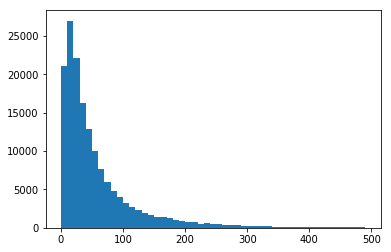

In [37]:
plt.hist(totalNumWords,bins = np.arange(0,500,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [38]:
inp = Input(shape=(maxlen, ))

In [159]:
embeddings_index = {}
f = open(os.path.join('glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [163]:
embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [164]:
embed_size = 128
x = Embedding(len(word_index)+1,50,weights=[embedding_matrix],input_length=embed_size,trainable=False)(inp)

In [165]:
x = LSTM(60, return_sequences=True,name='lstm_layer',activation='sigmoid')(x)

In [166]:
x = GlobalMaxPool1D()(x)

In [167]:
x = Dropout(0.1)(x)

In [168]:
x = Dense(50, activation="relu")(x)

In [169]:
x = Dropout(0.1)(x)

In [170]:
x = Dense(6, activation="sigmoid",activity_regularizer=l2(0.0001))(x)

In [171]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [172]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 688s 5ms/step - loss: 0.0806 - acc: 0.9738 - val_loss: 0.0639 - val_acc: 0.9782
Epoch 2/2
143613/143613 [==============================] - 681s 5ms/step - loss: 0.0636 - acc: 0.9780 - val_loss: 0.0596 - val_acc: 0.9791


In [173]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 128, 50)           10516900  
_________________________________________________________________
lstm_layer (LSTM)            (None, 128, 60)           26640     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 60)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
__________

In [174]:
model_json = model.to_json()
with open("model_LSTM.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_LSTM.h5")
print("Saved model to disk")

Saved model to disk


In [175]:
json_file = open('model_LSTM.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_LSTM.h5")
print("Loaded model from disk")

Loaded model from disk


In [176]:
y_pred = loaded_model.predict(X_te, batch_size=1024)
subm[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
subm.to_csv('submission_LSTM_v1.csv', index=False)